# Recursive forecasting example

In this notebook we will show how to use trend features in a recursive forecasting workflow where we also have features built from the target (e.g., lag & window features).

## Data Set Synopsis

We will use the Victoria electricity demand dataset found here: 
https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. This dataset is used in the [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf). It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015. A more detailed description of the dataset can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). 

We resampled the dataset to hourly in the 4th data preparation notebook in the "01-Create-Datasets" folder in this repo. For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

## References
[1] [K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
    MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple
    Seasonal Patterns. arXiv preprint arXiv:2107.13462.](https://arxiv.org/pdf/2107.13462.pdf)

In [2]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [24]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    parse_dates=["date_time"],
    index_col=["date_time"],
)

In [25]:
data.shape

(115368, 3)

In [26]:
data.head()

,demand,temperature,is_holiday
date_time,,,
2002-01-01 00:00:00,6919.366092,32.6,1
2002-01-01 01:00:00,7165.974188,32.6,1
2002-01-01 02:00:00,6406.542994,32.6,1
2002-01-01 03:00:00,5815.537828,32.6,1
2002-01-01 04:00:00,5497.732922,32.6,1


The dataset is very large, feel free to use more historical data if you're computer can handle it!

In [27]:
# Filter data to include 20120 onwards
data = data[data.index > "2012-01-01"]

## Plot the data

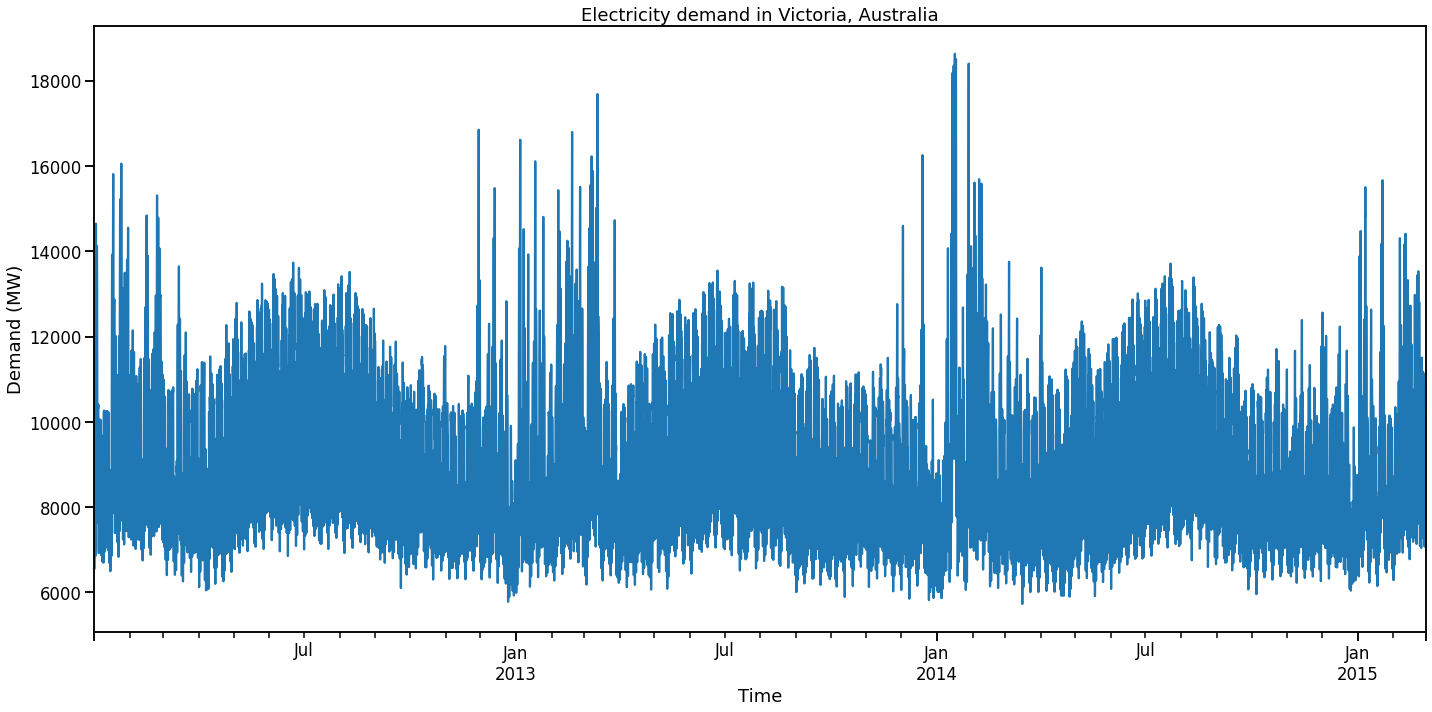

In [28]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="demand", figsize=[20, 10], legend=False, ax=ax)
ax.set_ylabel("Demand (MW)")
ax.set_xlabel("Time")
ax.set_title("Electricity demand in Victoria, Australia")
plt.tight_layout()

# Let's build some forecasts!

Let's build a recursive forecast and see how our trend feature can help!

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [31]:
# The data is monthly, let's work with pandas Period.
df = data.copy()
df.index = df.index.to_period("H")
df.head()

,demand,temperature,is_holiday
date_time,,,
2012-01-01 01:00,7901.826990,20.325,1
2012-01-01 02:00,7255.721350,19.850,1
2012-01-01 03:00,6792.503352,19.025,1
2012-01-01 04:00,6635.984460,18.725,1
2012-01-01 05:00,6548.104464,18.675,1


In [32]:
# Sanity check
df.isnull().any()

demand         False
temperature    False
is_holiday     False
dtype: bool

## Lag & window features

In [39]:
from sktime.transformations.series.summarize import WindowSummarizer

In [46]:
# Features computed from the target.
# Compute lag and window features.
lag_window_transformer = WindowSummarizer(
    lag_feature={
        "lag": [1, 24, 24*7, 24*365],  # Lag features.
        "mean": [[1, 24], [1, 24*7], [1, 24*31]]  # [[lag, window size]]
    },
    target_cols=["demand"],
    truncate="bfill", # Backfill missing values from lagging and windowing.
    )

In [53]:
lag_window_transformer.fit_transform(df["demand"])

,demand_lag_1,demand_lag_24,demand_lag_168,demand_lag_8760,demand_mean_1_24,demand_mean_1_168,demand_mean_1_744
date_time,,,,,,,
2012-01-01 01:00,7901.826990,7901.826990,7901.826990,7901.826990,9262.456202,9483.017597,9732.308143
2012-01-01 02:00,7901.826990,7901.826990,7901.826990,7901.826990,9262.456202,9483.017597,9732.308143
2012-01-01 03:00,7255.721350,7901.826990,7901.826990,7901.826990,9262.456202,9483.017597,9732.308143
2012-01-01 04:00,6792.503352,7901.826990,7901.826990,7901.826990,9262.456202,9483.017597,9732.308143
2012-01-01 05:00,6635.984460,7901.826990,7901.826990,7901.826990,9262.456202,9483.017597,9732.308143
...,...,...,...,...,...,...,...
2015-02-28 19:00,9979.909902,9980.108798,12259.011746,9481.092844,8802.565712,9670.463454,9534.348213
2015-02-28 20:00,9596.777060,9411.874558,11671.738690,9066.281590,8786.593557,9654.616819,9534.857244
2015-02-28 21:00,8883.230296,8653.510960,10657.184852,8322.859798,8764.566712,9638.018555,9534.319389


## Trend features

In [48]:
from sktime.transformations.series.time_since import TimeSince

Let's consider only the time feature to capture the trend.

In [50]:
time_since_transformer = TimeSince()
time_since_transformer.fit_transform(df.head())

,time_since_2012-01-01 01:00
date_time,
2012-01-01 01:00,0
2012-01-01 02:00,1
2012-01-01 03:00,2
2012-01-01 04:00,3
2012-01-01 05:00,4


## Datetime features

In [16]:
from sktime.transformations.series.date import DateTimeFeatures

In [54]:
date_time_trasformer = DateTimeFeatures(manual_selection=[
    "hour_of_day",
    "month_of_year",
    "day_of_week",
]
                                       )
date_time_trasformer.fit_transform(df.head())

,demand,temperature,is_holiday,hour_of_day,month_of_year,day_of_week
date_time,,,,,,
2012-01-01 01:00,7901.826990,20.325,1,1,1,6
2012-01-01 02:00,7255.721350,19.850,1,2,1,6
2012-01-01 03:00,6792.503352,19.025,1,3,1,6
2012-01-01 04:00,6635.984460,18.725,1,4,1,6
2012-01-01 05:00,6548.104464,18.675,1,5,1,6


## Seasonality features

Let's create transformers that will build features from the target variable. This will always be in a separate pipeline because for recursive forecasting we need to re-compute these features on each forecast step.

,y_lag_1,y_mean_1_12
ds,,
1949-01,112.0,126.166667
1949-02,112.0,126.166667
1949-03,118.0,126.166667
1949-04,132.0,126.166667
1949-05,129.0,126.166667
...,...,...
1960-08,622.0,459.416667
1960-09,606.0,463.333333
1960-10,508.0,467.083333


# Build pipelines

## Future known features

In [61]:
transformer = [date_time_trasformer + time_since_transformer
transformer.fit_transform(df["demand"])

date_time
2012-01-01 01:00        0
2012-01-01 02:00        1
2012-01-01 03:00        2
2012-01-01 04:00        3
2012-01-01 05:00        4
                    ...  
2015-02-28 19:00    27714
2015-02-28 20:00    27715
2015-02-28 21:00    27716
2015-02-28 22:00    27717
2015-02-28 23:00    27718
Freq: H, Length: 27719, dtype: int64

## Features built from the target

In [62]:
lag_window_transformer

WindowSummarizer(lag_feature={'lag': [1, 24, 168, 8760],
                              'mean': [[1, 24], [1, 168], [1, 744]]},
                 target_cols=['demand'], truncate='bfill')

Let's build a recursive forecast.

In [135]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split                                                    
forecast_start_period = pd.Period("1958-01", freq="M")
num_of_forecast_steps = 36 
target = ["y"]

model = LinearRegression()

fit_once = True # if True fit model once.
                # if False fit model on each iteration.

# --- CREATE DYNAMIC TRAINING DATAFRAME  --- #
# `df_train` is "dynamic" because we will dynamically append 
# the features built from the target to this dataframe. 
# It's "training" because we use this dataframe 
# to create the training set passed to the model.
forecast_periods = pd.period_range(forecast_start_period, 
                                   periods=num_of_forecast_steps,
                                   freq="M")

# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[:forecast_start_period].copy()

# Extend index to include the forecasting horizon.
# The target variable will be NaN in the forecasting horizon
# at this stage. As we iteratively make forecasts we will fill
# the missing values with forecasts.
df_train = pd.concat([
                      df_train,
                      pd.DataFrame(index=forecast_periods)
                     ], 
                     axis=1)

# --- FEATURE ENGINEERING FOR FUTURE KNOWN FEATURES --- #
# Here, we create any features where we already know 
# the feature value in the forecast horizon (i.e., the future).
# Hence, we can compute them just once and outside of the
# recursive forecasting loop that will follow.

# Create features from date and time.
X_time_features = time_since_transformer.fit_transform(df_train)


# --- RECURSIVE FORECASTING LOOP --- #
_model_is_not_fitted = True
for forecast_period in forecast_periods:    
    # --- FEATURE ENGINEERING FROM TARGET --- #
    # Create lag & window features.
    X_target_features = lag_window_transformer.fit_transform(df_train)

    # --- CREATE TRAIN AND TEST (PREDICT) SET --- #
    # Join the features onto the target, this  makes it easy to
    # inspect the features and target manually.
    df_y_and_X = pd.concat([
                            df_train[target], 
                            X_time_features, 
                            X_target_features,
                           ], axis=1)
    
    
    # Get feature names.
    features = df_y_and_X.columns.drop(labels=target)
    
    # Filter on forecast period to get training set.
    train_mask = df_y_and_X.index < forecast_period
    X_train = df_y_and_X.loc[train_mask, features]
    y_train = df_y_and_X.loc[train_mask, target]
    
    # Filter on forecast date to get test set (predict set). 
    # We're forecasting one step ahead at a time,
    # so there is only one row in X_test!
    X_test = df_y_and_X.loc[[forecast_period], features]

    # --- MAKE FORECAST --- #
    # Train a model. 
    #
    # If `fit_once` is True then the model
    # is trained only once, on the first
    # iteration, and then never again.
    #
    # If `fit_once` is False then the model 
    # is trained on the dyanmically expanding
    # training dataframe on each iteration.
    if fit_once and _model_is_not_fitted:
        model.fit(X_train, y_train)
        _model_is_not_fitted = False
    elif fit_once is False:
        model.fit(X_train, y_train)
    
    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic training dataframe `df_train`. This `df_train`
    # is ready for the next iteration where we will re-compute
    # features derived from the target.
    df_train.loc[forecast_period, target] = y_pred[0]

In [146]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
# Create predictions on the training set 
# using the one step ahead forecast model.
# Useful to plot when debugging models.
train_mask = df_y_and_X.index < forecast_start_period
X_train = df_y_and_X.loc[train_mask, features]
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame({"y":y_forecast_train.flatten()}, index=X_train.index)

In [147]:
# --- CONVENIENT POST PROCESSING--- #

# Fill in last forecast in the dataframe that contains
# target and features.
df_y_and_X.loc[forecast_period, target] = y_pred[0]

# Retreive forecast and actuals
y_forecast = df_train.loc[forecast_start_period:, target]
y_train = df.loc[:forecast_start_period, target]
y_test = df.loc[forecast_start_period:, target]

Text(0.5, 1.0, 'Air passenger numbers')

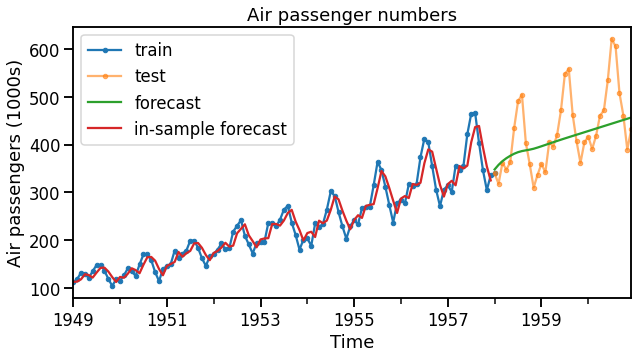

In [148]:
# --- PLOTTING --- #

# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train.loc[:forecast_start_period,["y"]].plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")

Let's compute the RMSE of this forecast.

In [149]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(y_forecast, y_test.loc[y_forecast.index], squared=False)

69.35369662377965

What about LASSO and Ridge which need feature scaling?

We can conveniently attach the feature scaling step to the model using a pipeline.

In [132]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
                        ('scaler', MinMaxScaler()), 
                        ('model', Ridge()),
])

This model with feature scaling can now be inserted at the top of the recursive forecasting code block.

We can now implement the time feature to capture trend alongside other features in a recursive forecasting workflow. We can see that the time feature can help capture the trend in the data when using linear models.

Feel free to change the dates, try different models, and different features!